In [ ]:
## Mount Google Drive ##
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
## Google Colab path ##
# path = r'/content/drive/My Drive/Colab Notebooks/'

In [ ]:
#### THESE STEPS ARE USED FOR PROCESSING RAW DATA ####
#### ONCE PROCESSED, SKIP THESE STEPS UNLESS PROCESSING DATA WITH NEW PARAMETERS ####

In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import glob
import os

## Raw Data Folder path ##
raw_files = glob.glob(os.getcwd() + "/data/*.csv")

frame = []

for filename in raw_files:
    li = pd.read_csv(filename).drop('timestamp', axis=1).reset_index()
    frame.append(li)
    
def name_encoder(name):
    switcher = {
        'alex': 0,
        'hara': 1,
        'jt': 2,
        'kuro': 3,
        'lee': 4,
        'matsu': 5,
        'miya': 6,
        'nishio': 7,
        'okada': 8,
        'shun': 9,
        'tei': 10,
        'tera': 11,
        'yama': 12
    }
    return switcher.get(name,"Invalid name")

In [ ]:
def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal

In [ ]:
## Separate each gesture ##
f_frame = [pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]
f_frame_rs = [pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]

## Parameters for signal processing ##
RESAMPLING_RATE = 600
b1, a1 = signal.butter(2, 10/100, "Low")
# b2, a2 = signal.butter(2, [51/100,99/100], "Band")

n = 0
for i in range(len(frame)):
    k = 0
    l = 0
    print(i, frame[i]['performer'][0])
#     y = int(name_encoder(frame[i]['performer'][0]))
    for j in range(len(frame[i])):
        f_frame_temp = pd.DataFrame(columns = ['emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8','Lemg1','Lemg2','Lemg3','Lemg4','Lemg5','Lemg6','Lemg7','Lemg8','performer','gesture','data','data2'])
        f_frame_rs_temp = pd.DataFrame(columns = ['emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8','Lemg1','Lemg2','Lemg3','Lemg4','Lemg5','Lemg6','Lemg7','Lemg8','performer','gesture','data','data2','time'])
        if((pd.isna(frame[i].loc[j]).any() and not(frame[i][k:j].empty) and not(frame[i][k:j].isnull().values.any())) or (j==(len(frame[i]) - 1) and not(frame[i][k:j].empty) and not(frame[i][k:j].isnull().values.any()))) and l<5:
            for m in range(1, 9):
                f_frame_temp['emg' + str(m)] = frame[i][k:j]['emg' + str(m)]
                f_frame_temp['Lemg' + str(m)] = signal.filtfilt(b1, a1, abs(frame[i][k:j]['emg' + str(m)]))
                f_frame_rs_temp['emg' + str(m)] = resample_by_interpolation(frame[i][k:j]['emg' + str(m)], len(frame[i][k:j]), RESAMPLING_RATE)
                f_frame_rs_temp['Lemg' + str(m)] = resample_by_interpolation(signal.filtfilt(b1, a1, abs(frame[i][k:j]['emg' + str(m)])), len(frame[i][k:j]), RESAMPLING_RATE)
            f_frame_temp['performer'] = name_encoder(frame[i]['performer'][0])
            f_frame_temp['gesture'] = name_encoder(frame[i]['gesture'][0])
            f_frame_temp['situation'] = frame[i]['situation'][0]
            f_frame_temp['data'] = i
            f_frame_temp['data2'] = n
            f_frame_rs_temp['time'] = resample_by_interpolation(frame[i][k:j].reset_index().index, len(frame[i][k:j]), RESAMPLING_RATE)
            f_frame_rs_temp['performer'] = name_encoder(frame[i]['performer'][0])
            f_frame_rs_temp['gesture'] = name_encoder(frame[i]['gesture'][0])
            f_frame_rs_temp['situation'] = frame[i]['situation'][0]
            f_frame_rs_temp['data'] = i
            f_frame_rs_temp['data2'] = n
            y = int(f_frame_temp['performer'][k])
            f_frame[y] = pd.concat([f_frame[y], f_frame_temp])
            f_frame_rs[y] = pd.concat([f_frame_rs[y], f_frame_rs_temp])
            k = j + 1
            l = l + 1
            n = n + 1

for x in range(len(f_frame)):
    f_frame[x].to_csv (str(x)+'nonrs.csv', index = False, header=True)
    f_frame_rs[x].to_csv (str(x)+'rs.csv', index = False, header=True)

In [1]:
## Import libraries and data ##
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import signal
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import glob
import os
# from google.colab import files

file = glob.glob(os.getcwd() + "/nonrs_data/*.csv")
file_rs = glob.glob(os.getcwd() + "/rs_data/*.csv")

frame = []
frame_rs = []

for filename in file:
    li = pd.read_csv(filename)
    frame.append(li)
for filename2 in file_rs:
    li2 = pd.read_csv(filename2)
    frame_rs.append(li2)
    
# PARTICIPANTS = ['alex', 'hara', 'jt', 'kuro', 'lee', 'matsu', 'miya', 'nishio', 'okada', 'shun', 'tei', 'tera', 'yama']
PARTICIPANTS = ['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10', '#11', '#12', '#13']
PERFORMER = 'performer'
GESTURE = 'gesture'

def name_encoder(name):
    switcher = {
        'alex': 0,
        'hara': 1,
        'jt': 2,
        'kuro': 3,
        'lee': 4,
        'matsu': 5,
        'miya': 6,
        'nishio': 7,
        'okada': 8,
        'shun': 9,
        'tei': 10,
        'tera': 11,
        'yama': 12
    }
    return switcher.get(name,"Invalid name")

In [2]:
f_frame = []
# for i in range (len(frame)):
#     for j, k in frame[i].groupby('data2'):
#         f_frame.append(k)
for i in range(len(frame_rs)):
    for j, k in frame_rs[i].groupby('data2'):
        f_frame.append(k)

In [12]:
## Initiate variables ##
WINDOW_SIZE = 600
SLIDING_RATE = 100
TRAIN_NUM = 2
TEST_NUM = 2
EPOCHS = 20
HIDDEN_LAYERS = 10
NODES = 100
ROTATIONS = True

In [4]:
f_train = []
f_test = []
a=0
for i in range(len(PARTICIPANTS)):
    k = 0
    l = 0
    m = 0
    n = 0
    o = 0
    p = 0
    f_test_temp = -1
    for j in range(len(f_frame)):
        f_frame[j].reset_index(drop=True, inplace=True)
###########################################################        
## Single Scenario / Mixed Scenario Training and Testing ##
###########################################################
#         TRAIN_SCENARIO = 'x5 Sit-Stand-Walk'
#         TEST_SCENARIO = 'x5 Sit-Stand-Walk'
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'sit'):
#             if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
#                 f_train.append(f_frame[j])
#             elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
#                 f_test.append(f_frame[j])
#             else:
#                 k = k + 1
#                 if(k<=TRAIN_NUM):
#                     f_train.append(f_frame[j])
#                 elif(k>TRAIN_NUM):
#                     l = l + 1
#                     if(l<=TEST_NUM):
#                         f_test.append(f_frame[j])
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'stand'):
#             if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
#                 f_train.append(f_frame[j])
#             elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
#                 f_test.append(f_frame[j])
#             else:
#                 m = m + 1
#                 if(m<=TRAIN_NUM):
#                     f_train.append(f_frame[j])
#                 elif(m>TRAIN_NUM):
#                     n = n + 1
#                     if(n<=TEST_NUM):
#                         f_test.append(f_frame[j])         
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'walk'):
#             if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
#                 f_train.append(f_frame[j])
#             elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
#                 f_test.append(f_frame[j])
#             else:
#                 o = o + 1
#                 if(o<=TRAIN_NUM):
#                     f_train.append(f_frame[j])
#                 elif(o>TRAIN_NUM):
#                     p = p + 1
#                     if(p<=TEST_NUM):
#                         f_test.append(f_frame[j]) 
#         TRAIN_SCENARIO = TRAIN_SCENARIO + " + Mimic Training" 
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] != i):
#             f_train.append(f_frame[j])
            
##########################################################
## 1 Scenario Training, 1 Scenario Training and Testing ##
##########################################################
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'stand'):
#             if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
#                 f_train.append(f_frame[j])
#             else:
#                 k = k + 1
#                 if(k<=TRAIN_NUM):
#                     f_train.append(f_frame[j])
#         elif(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'sit'):
#             if(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
#                 f_test.append(f_frame[j])
#             else:
#                 if(f_test_temp != f_frame[j]['data'][0]):
#                     f_test_temp = f_frame[j]['data'][0]
#                     n = n + 1
#                 if(n>TRAIN_NUM):
#                     m = m + 1
#                     if(m<=TEST_NUM):
#                         f_test.append(f_frame[j])

#################################################
## 1 or 2 Scenario Training 1 Scenario Testing ##
#################################################
#         TRAIN_SCENARIO_1 = 'walk'
# #         TRAIN_SCENARIO_2 = 'stand'
#         TEST_SCENARIO_1 = 'stand'
#         TRAIN_SCENARIO = ' ' + TRAIN_SCENARIO_1.title() #+ "-" + TRAIN_SCENARIO_2.title()
#         TEST_SCENARIO = ' ' + TEST_SCENARIO_1.title()
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and (f_frame[j]['situation'][0] == TRAIN_SCENARIO_1)): #or f_frame[j]['situation'][0] == TRAIN_SCENARIO_2)):
#             f_train.append(f_frame[j])
#         elif(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == TEST_SCENARIO_1):
#             f_test.append(f_frame[j])
#             k = k + 1

###################
## Mimic Testing ##
###################
        TRAIN_SCENARIO = 'x5 Sit-Stand-Walk + 4x5 Sit-Stand-Walk Mimic'
        TEST_SCENARIO = 'x5 Mimic'
#         if((f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i)):
#             f_train.append(f_frame[j])
#             k = k + 1
        if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'sit'):
            if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
                f_train.append(f_frame[j])
            elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
                f_test.append(f_frame[j])
            else:
                k = k + 1
                if(k<=TRAIN_NUM):
                    f_train.append(f_frame[j])
        if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'stand'):
            if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
                f_train.append(f_frame[j])
            elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
                f_test.append(f_frame[j])
            else:
                m = m + 1
                if(m<=TRAIN_NUM):
                    f_train.append(f_frame[j])
        if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'walk'):
            if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
                f_train.append(f_frame[j])
            elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
                f_test.append(f_frame[j])
            else:
                o = o + 1
                if(o<=TRAIN_NUM):
                    f_train.append(f_frame[j])
        elif((f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] != i and f_frame[j]['situation'][0] != 'mimic')):
            f_train.append(f_frame[j])
        elif(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] != i and f_frame[j]['situation'][0] == 'mimic'):
            f_test.append(f_frame[j])

#############################        
## Single Gesture Training ##
#############################
#         TRAIN_SCENARIO = 'x1 Sit-Stand-Walk'
#         TEST_SCENARIO = 'x5 Sit-Stand-Walk'
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'sit'):
#             if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
#                 pass
#             elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
#                 f_test.append(f_frame[j])
#             else:
#                 k = k + 1
#                 if(k<=TRAIN_NUM):
#                     f_train.append(f_frame[j])
#                 elif(k>TRAIN_NUM):
#                     l = l + 1
#                     if(l<=TEST_NUM):
#                         f_test.append(f_frame[j])
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'stand'):
#             if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
#                 pass
#             elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
#                 f_test.append(f_frame[j])
#             else:
#                 m = m + 1
#                 if(m<=TRAIN_NUM):
#                     f_train.append(f_frame[j])
#                 elif(m>TRAIN_NUM):
#                     n = n + 1
#                     if(n<=TEST_NUM):
#                         f_test.append(f_frame[j])         
#         if(f_frame[j]['performer'][0] == i and f_frame[j]['gesture'][0] == i and f_frame[j]['situation'][0] == 'walk'):
#             if(f_train and f_frame[j]['data'][0] == f_train[len(f_train)-1]['data'][0]):
#                 pass
#             elif(f_test and f_frame[j]['data'][0] == f_test[len(f_test)-1]['data'][0]):
#                 f_test.append(f_frame[j])
#             else:
#                 o = o + 1
#                 if(o<=TRAIN_NUM):
#                     f_train.append(f_frame[j])
#                 elif(o>TRAIN_NUM):
#                     p = p + 1
#                     if(p<=TEST_NUM):
#                         f_test.append(f_frame[j]) 
            
df_train = pd.concat(f_train)
df_test = pd.concat(f_test)

In [5]:
# print(f_train[300], f_train[658])
# %matplotlib inline

# plt.figure(figsize=(27, 9))
# plt.plot(f_train[250]['emg1'])
# plt.plot(f_train[0]['Lemg1'])
# #plt.scatter(x, max_y_pred_test[50000:70000], s=0.001)
# #plt.plot(max_y_test)
# plt.show()
# print((df_train['performer'][0:120537]))
print(len(f_train), len(f_test))

1227 279


In [13]:
def create_segments_and_labels(df, windows, slide, performer_name, gesture_name, virtual_rotation, data_type):
# def create_segments_and_labels(df, windows, slide, performer_name):
    # 8 EMG sensors as features
    N_FEATURES = 9
    # Number of slides to advance in each iteration (for me, it should always
    # be equal to the windows in order to have no overlap between segments)
    # slide = windows
    segments = []
    performers = []
    gestures = []
    
    for i in range(0, len(df) - windows + 1, slide):
        e1 = df['Lemg1'].values[i: i + windows]
        e2 = df['Lemg2'].values[i: i + windows]
        e3 = df['Lemg3'].values[i: i + windows]
        e4 = df['Lemg4'].values[i: i + windows]
        e5 = df['Lemg5'].values[i: i + windows]
        e6 = df['Lemg6'].values[i: i + windows]
        e7 = df['Lemg7'].values[i: i + windows]
        e8 = df['Lemg8'].values[i: i + windows] 
#         e1 = df['emg1'].values[i: i + windows]
#         e2 = df['emg2'].values[i: i + windows]
#         e3 = df['emg3'].values[i: i + windows]
#         e4 = df['emg4'].values[i: i + windows]
#         e5 = df['emg5'].values[i: i + windows]
#         e6 = df['emg6'].values[i: i + windows]
#         e7 = df['emg7'].values[i: i + windows]
#         e8 = df['emg8'].values[i: i + windows] 
        t = df['time'].values[i: i + windows]
        # Retrieve the most often used label in this segment
#         print(df[performer_name][i: i + windows])
        performer = stats.mode(df[performer_name][i: i + windows])[0][0]
        gesture = stats.mode(df[gesture_name][i: i + windows])[0][0]
        k = [e1,e2,e3,e4,e5,e6,e7,e8]
        # k = [f1,f2,f3,f4,f5,f6,f7,f8]
        ## Virtual Rotating Device ##
        ROTATION = 'Rotation'
        if(virtual_rotation and data_type == 'train'):
            for j in range(8):
                k = (k[1:] + k[:1])
                l = []
                l = (k[1:] + k[:1])
                l.append(t)
                segments.append(l)
                performers.append(performer)
        else:
            k.append(t)
            segments.append(k)
            performers.append(performer)
        
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, windows, N_FEATURES)
#     performers = np.asarray([performers, gestures])
    performers = np.asarray([performers])
    return reshaped_segments, performers
    

# Add a new column to the existing DataFrame with the encoded values
x_train, y_train = create_segments_and_labels(df_train, WINDOW_SIZE, SLIDING_RATE, PERFORMER, GESTURE, ROTATIONS, 'train')
x_test, y_test = create_segments_and_labels(df_test, WINDOW_SIZE, SLIDING_RATE, PERFORMER, GESTURE, ROTATIONS, 'test')

In [14]:
# Set input & output dimensions
num_windows, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = len(PARTICIPANTS)
print(num_windows, num_sensors)

600 9


In [15]:
input_shape = (num_windows*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_test = x_test.reshape(x_test.shape[0], input_shape)
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_train_hot = to_categorical(y_train[0], num_classes)
y_test_hot = to_categorical(y_test[0], num_classes)

# print('x_train shape: ', x_train[i].shape)
# print('x_test shape: ',x_test[i].shape)
# print(x_train[i].shape[0], 'training samples')
# print('y_train shape: ', y_train[i].shape)
# print('x_train shape:', x_train[i].shape)
# print('input_shape:', input_shape[i])
print('New y_train shape: ', y_train_hot.shape)
print('New y_test shape: ', y_test_hot.shape)

New y_train shape:  (58856, 13)
New y_test shape:  (1669, 13)


In [16]:
model_m = Sequential()
model_m.add(Reshape((WINDOW_SIZE, num_sensors), input_shape=(input_shape,)))
for h in range(HIDDEN_LAYERS):
#     model_m.add(Dense(NODES, activation='sigmoid'))
    model_m.add(Dense(NODES, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# from tensorflow.keras.layers import Input
# from tensorflow.keras.models import Model

# inputs = Input(shape=(input_shape,))
# x = Dense(NODES, activation="relu")(inputs)
# for h in range(HIDDEN_LAYERS - 1):
#     x = Dense(NODES, activation="relu")(x)
# x = Dense(NODES, activation="linear")(x)
# model = Model(inputs, x)
# print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 600, 9)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 600, 100)          1000      
_________________________________________________________________
dense_12 (Dense)             (None, 600, 100)          10100     
_________________________________________________________________
dense_13 (Dense)             (None, 600, 100)          10100     
_________________________________________________________________
dense_14 (Dense)             (None, 600, 100)          10100     
_________________________________________________________________
dense_15 (Dense)             (None, 600, 100)          10100     
_________________________________________________________________
dense_16 (Dense)             (None, 600, 100)         

In [17]:
print(input_shape)

5400


In [18]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

# Hyper-parameters
BATCH_SIZE = 1000

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = []
results = []
y_pred_test = []
max_y_pred_test = []
max_y_test = []

model_m.compile(loss='categorical_crossentropy',
            optimizer='adam', metrics=['accuracy'])
history.append(model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS))
                      #callbacks=callbacks_list,
                      #validation_split=0.001,
                      #verbose=1))
results.append(model_m.evaluate(x_test, y_test_hot))
print(results)
y_pred_test.append(model_m.predict(x_test))
# Take the class with the highest probability from the test predictions
max_y_pred_test.append(np.argmax(model_m.predict(x_test), axis=1))
max_y_test.append(np.argmax(y_test_hot, axis=1))

Train on 58856 samples
Epoch 1/20
58856/58856 [==============================] - 18s 305us/sample - loss: 2.3251 - accuracy: 0.2705
Epoch 2/20
58856/58856 [==============================] - 17s 281us/sample - loss: 1.5301 - accuracy: 0.4695
Epoch 3/20
58856/58856 [==============================] - 17s 282us/sample - loss: 1.3037 - accuracy: 0.5440
Epoch 4/20
58856/58856 [==============================] - 17s 282us/sample - loss: 1.1293 - accuracy: 0.6062
Epoch 5/20
58856/58856 [==============================] - 17s 282us/sample - loss: 0.9754 - accuracy: 0.6565
Epoch 6/20
58856/58856 [==============================] - 17s 282us/sample - loss: 0.8643 - accuracy: 0.6981
Epoch 7/20
58856/58856 [==============================] - 17s 283us/sample - loss: 0.7599 - accuracy: 0.7355
Epoch 8/20
58856/58856 [==============================] - 17s 282us/sample - loss: 0.6482 - accuracy: 0.7764
Epoch 9/20
58856/58856 [==============================] - 17s 283us/sample - loss: 0.5875 - accuracy: 0.7

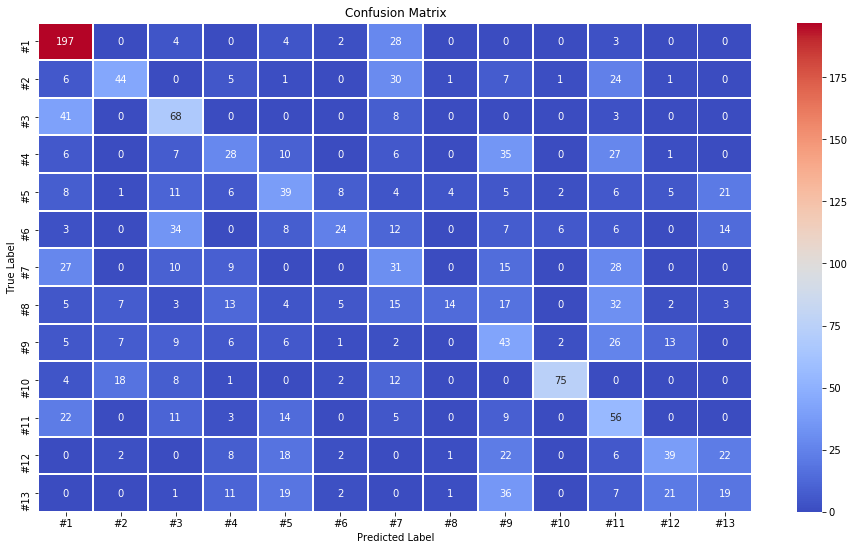

              precision    recall  f1-score   support

           0       0.61      0.83      0.70       238
           1       0.56      0.37      0.44       120
           2       0.41      0.57      0.48       120
           3       0.31      0.23      0.27       120
           4       0.32      0.33      0.32       120
           5       0.52      0.21      0.30       114
           6       0.20      0.26      0.23       120
           7       0.67      0.12      0.20       120
           8       0.22      0.36      0.27       120
           9       0.87      0.62      0.73       120
          10       0.25      0.47      0.33       120
          11       0.48      0.33      0.39       120
          12       0.24      0.16      0.19       117

    accuracy                           0.41      1669
   macro avg       0.43      0.37      0.37      1669
weighted avg       0.45      0.41      0.40      1669



In [19]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(16, 9))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=PARTICIPANTS,
                yticklabels=PARTICIPANTS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

In [ ]:
# plt.text(0.01, 0.05, classification_report(max_y_test, max_y_pred_test), fontproperties = 'monospace') # approach improved by OP -> monospace!
# plt.axis('off')
# plt.show()
# plt.savefig('output.png')

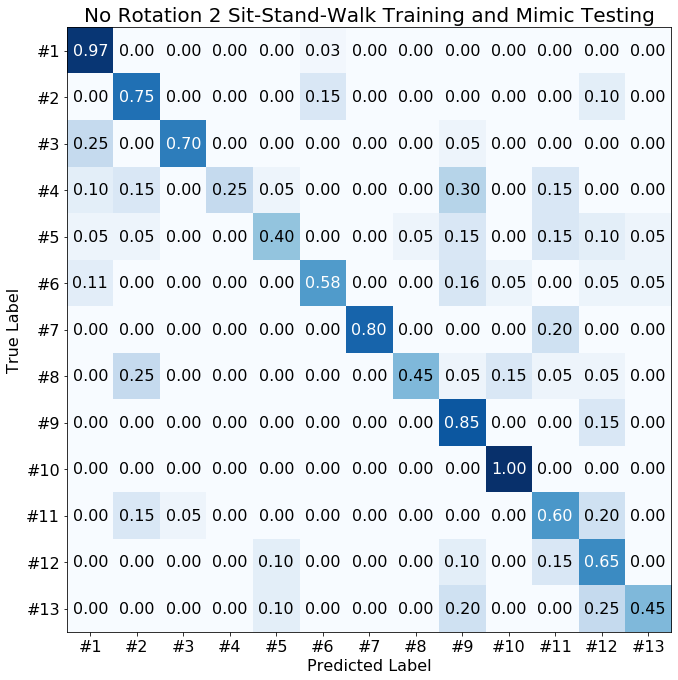

In [53]:
if(ROTATIONS):
    ROTATION = 'Rotation '
else:
    ROTATION = 'No Rotation '
# FILE_NAME = ROTATION + str(TRAIN_NUM) + TRAIN_SCENARIO + " " + str(TEST_NUM) + TEST_SCENARIO + " Testing"
FILE_NAME = ROTATION + str(TRAIN_NUM) + " Sit-Stand-Walk Training and Mimic Testing"

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(16, 9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]))
    ax.set_xticklabels(classes,fontsize=16)
    ax.set_yticklabels(classes,fontsize=16)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=16)
    fig.tight_layout()
    plt.title(title, fontsize=20)
    plt.ylabel('True Label', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.rc('xtick', labelsize=16)
    plt.savefig(FILE_NAME + '.png', dpi=300, bbox_inches='tight')
    
    return ax

# Plot normalized confusion matrix
plot_confusion_matrix(max_y_test, max_y_pred_test, PARTICIPANTS, normalize=True, title=FILE_NAME)
# files.download(FILE_NAME + '.png')

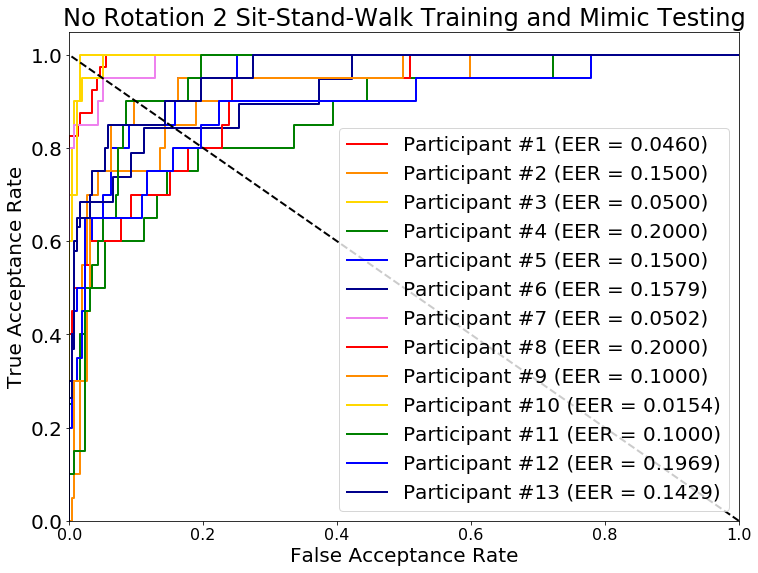

    EER
0 : 0.0460
1 : 0.1500
2 : 0.0500
3 : 0.2000
4 : 0.1500
5 : 0.1579
6 : 0.0502
7 : 0.2000
8 : 0.1000
9 : 0.0154
10 : 0.1000
11 : 0.1969
12 : 0.1429


In [54]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

from scipy.optimize import brentq
from scipy.interpolate import interp1d

lw = 2

fpr = dict()
tpr = dict()
thres = dict()
roc_auc = dict()
eer = []
# thresh = []

for j in range(num_classes):
    fpr[j], tpr[j], thres[j] = roc_curve(y_test_hot[:, j], y_pred_test[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])
    eer.append(brentq(lambda x : 1. - x - interp1d(fpr[j], tpr[j])(x), 0., 1.))
#     print(eer[j], fpr[j], tpr[j])
#     thresh.append(interp1d(fpr[j], thres[j])(eer[j]))
        

plt.figure(figsize=(12, 9))
colors = cycle(['red', 'darkorange', 'gold', 'green', 'blue', 'darkblue', 'violet'])
for k, color in zip(range(num_classes), colors):
    plt.plot(fpr[k], tpr[k], color=color, lw=lw,
    label= 'Participant #' + str(k+1) + ' (EER = {1:0.4f})'.format(k, eer[k]))
             #{0}(area = {1:0.4f})'''.format(k, roc_auc[k])+', 
        
plt.plot([1, 0], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20) 
plt.xlabel('False Acceptance Rate', fontsize=20)
plt.ylabel('True Acceptance Rate', fontsize=20)
plt.title(FILE_NAME, fontsize=24)
plt.legend(loc="lower right", fontsize=20)
plt.savefig(FILE_NAME + '_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

# files.download(FILE_NAME + '_ROC.png')

#print("    EER\t\t Accuracy\t Threshold")
print("    EER")
for j in range(num_classes):
    #print(j, ":", "{0:.4f}".format(eer[j]), " \t", "{0:.4f}".format(1-eer[j]), "\t" , "{0:.4f}".format(thresh[j]))
    print(j, ":", "{0:.4f}".format(eer[j]))